In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables
x0 = VariableVector(cAl2O3=3.5, deltagrate=0.04, ACD=2.9193, deltaI=0.0)
x0.dictionary

{'cAl2O3': 0, 'deltagrate': 1, 'ACD': 2, 'deltaI': 3}

In [8]:
# Create Input Vector Variables
u0 = VariableVector(g0=0.0, B=0.0, I0=126000.0, )
u0.dictionary

{'g0': 0, 'B': 1, 'I0': 2}

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858, Icell=126000.0)
z0.dictionary

{'Vcell': 0, 'Icell': 1}

### Removed delta_I dependency on previous value

In [10]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(4, 4, 1)
# Identity matrix for the terms independent of dT, except the delta I term
F0 = np.identity(4, dtype=float)
F0[3, 3] = 0.0
F.set_array_layer(0, F0)

True

### Corrected 2nd term first row for dimensional consistency and conservation of mass

In [11]:
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, 100/bbcell.m, 0.0, -gamma/bbcell.m],
                               [0.0, -bbcell.kdiss, 0.0, 0.0],
                               [0.0, 0.0, 0.0, bbcell.alpha],
                               [0.0, 0.0, 0.0, 0.0]]))

True

In [12]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  2.77777778e-01,  0.00000000e+00,
        -4.62315993e-08],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [13]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(4, 4, 2)
G.set_array_layer(0, np.zeros((4,4)))
layer1 = np.identity(4, dtype=float)
layer1[1,1] = 0.0
G.set_array_layer(1, layer1)
layer2 = np.zeros((4,4), dtype=float)
layer2[1,1] = 0.5
G.set_array_layer(2, layer2)

True

In [14]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[ 5. ,  0. ,  0. ,  0. ],
       [ 0. , 12.5,  0. ,  0. ],
       [ 0. ,  0. ,  5. ,  0. ],
       [ 0. ,  0. ,  0. ,  5. ]])

### Corrected first element for dimensional consistency (wt%)

In [15]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(4, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, bbcell.alpha], [0.0, 0.0, 0.0]]))

True

In [16]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-02,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [17]:
# Define the UKF noise standard deviations - needed to back off on first 2 states for simulation
q1std = 0.00002    # 0.0002 alumina concentration variation (wt%)
q2std = 0.0001       # 0.2 alumina feed mass discrepancy (kg/sec)
q3std = 0.0000001  # 0.0000001 acd varation needs to be much lower (cm)
q4std = 30         # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(4, 4, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0, 0.0],
                               [0.0, q2std**2, 0.0, 0.0],
                               [0.0, 0.0, q3std**2, 0.0],
                               [0.0, 0.0, 0.0, q4std**2]]))
Q.array_display

array([[[4.e-10, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-08, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 9.e+02]]])

In [18]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 20          # 50 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.e-06, 0.e+00],
        [0.e+00, 4.e+02]]])

In [19]:
from Refactor.UKFClass import DiscreteModel

In [20]:
alumina4state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [21]:
alumina4state.defined

True

In [22]:
alumina4state.x0.vector

array([[3.5   ],
       [0.04  ],
       [2.9193],
       [0.    ]])

In [23]:
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack

In [24]:
UKF4state = UKF(alumina4state, bbcell, x0, 5)

In [25]:
UKF4state.initialised

True

In [26]:
UKF4state.update_timestep(5)

False

In [27]:
UKF4state.Qm

array([[1.0000e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 1.5625e-06, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 2.5000e-13, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2500e+04]])

In [28]:
UKF4state.Rm

array([[1.e-06, 0.e+00],
       [0.e+00, 4.e+02]])

In [29]:
UKF4state.dT

5

In [30]:
# predict the state for next timestep using the current input and state vectors
UKF4state.predict_state(u0, 5)

True

In [31]:
UKF4state.uk.vector

array([[     0.],
       [     0.],
       [126000.]])

In [32]:
UKF4state.Ppred

array([[1.30711362e-05, 4.29687500e-05, 1.71312744e-11, 0.00000000e+00],
       [4.29687500e-05, 1.54703125e-04, 0.00000000e+00, 0.00000000e+00],
       [1.71312744e-11, 0.00000000e+00, 2.53110266e-11, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.25000000e+04]])

In [33]:
UKF4state.predictionflag

True

In [34]:
# the next timestep prediction
UKF4state.xpred.vector

array([[3.50528593],
       [0.0396    ],
       [2.91927925],
       [0.        ]])

In [35]:
# calling the UKF method to see the UKF samples generated around xpred
UKF4state.ukf_gen_samples()

(True,
 array([[[ 3.50528593e+00],
         [ 3.96000000e-02],
         [ 2.91927925e+00],
         [ 0.00000000e+00]],
 
        [[ 3.51337022e+00],
         [ 6.61754760e-02],
         [ 2.91927926e+00],
         [ 0.00000000e+00]],
 
        [[ 3.49720164e+00],
         [ 1.30245240e-02],
         [ 2.91927924e+00],
         [ 0.00000000e+00]],
 
        [[ 3.50528593e+00],
         [ 4.78012012e-02],
         [ 2.91927921e+00],
         [ 0.00000000e+00]],
 
        [[ 3.50528593e+00],
         [ 3.13987988e-02],
         [ 2.91927928e+00],
         [ 0.00000000e+00]],
 
        [[ 3.50528593e+00],
         [ 3.96000000e-02],
         [ 2.91929050e+00],
         [ 0.00000000e+00]],
 
        [[ 3.50528593e+00],
         [ 3.96000000e-02],
         [ 2.91926800e+00],
         [ 0.00000000e+00]],
 
        [[ 3.50528593e+00],
         [ 3.96000000e-02],
         [ 2.91927925e+00],
         [ 3.35410197e+02]],
 
        [[ 3.50528593e+00],
         [ 3.96000000e-02],
         [ 2.9192

In [36]:
# generate a new observation
z1 = clone_vector(z0)
z1.setvariable('Vcell', 4.47010343)
z1.setvariable('Icell', 126075)
z1.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [37]:
# perform and update step with the new observation
UKF4state.update_state(z1)

True

In [38]:
UKF4state.xpredsamples

array([[[ 3.50528593e+00],
        [ 3.96000000e-02],
        [ 2.91927925e+00],
        [ 0.00000000e+00]],

       [[ 3.51337022e+00],
        [ 6.61754760e-02],
        [ 2.91927926e+00],
        [ 0.00000000e+00]],

       [[ 3.49720164e+00],
        [ 1.30245240e-02],
        [ 2.91927924e+00],
        [ 0.00000000e+00]],

       [[ 3.50528593e+00],
        [ 4.78012012e-02],
        [ 2.91927921e+00],
        [ 0.00000000e+00]],

       [[ 3.50528593e+00],
        [ 3.13987988e-02],
        [ 2.91927928e+00],
        [ 0.00000000e+00]],

       [[ 3.50528593e+00],
        [ 3.96000000e-02],
        [ 2.91929050e+00],
        [ 0.00000000e+00]],

       [[ 3.50528593e+00],
        [ 3.96000000e-02],
        [ 2.91926800e+00],
        [ 0.00000000e+00]],

       [[ 3.50528593e+00],
        [ 3.96000000e-02],
        [ 2.91927925e+00],
        [ 3.35410197e+02]],

       [[ 3.50528593e+00],
        [ 3.96000000e-02],
        [ 2.91927925e+00],
        [-3.35410197e+02]]])

In [39]:
UKF4state.zpredsamples

array([[[4.46773694e+00],
        [1.26000000e+05]],

       [[4.46760040e+00],
        [1.26000000e+05]],

       [[4.46787561e+00],
        [1.26000000e+05]],

       [[4.46773692e+00],
        [1.26000000e+05]],

       [[4.46773695e+00],
        [1.26000000e+05]],

       [[4.46774241e+00],
        [1.26000000e+05]],

       [[4.46773146e+00],
        [1.26000000e+05]],

       [[4.47521248e+00],
        [1.26335410e+05]],

       [[4.46026038e+00],
        [1.25664590e+05]]])

In [40]:
UKF4state.innov

array([[2.36637925e-03],
       [7.50000000e+01]])

In [41]:
UKF4state.zbar

array([[4.46773705e+00],
       [1.26000000e+05]])

In [42]:
UKF4state.Pzz

array([[1.11820560e-05, 5.01508635e-01],
       [5.01508635e-01, 2.25000000e+04]])

In [43]:
UKF4state.xest.vector

array([[3.50515161e+00],
       [3.91584355e-02],
       [2.91927926e+00],
       [7.89784941e+01]])

In [44]:
UKF4state.innov_cov

array([[1.21820560e-05, 5.01508635e-01],
       [5.01508635e-01, 2.29000000e+04]])

In [45]:
UKF4state.Pxz

array([[-2.22487600e-07,  0.00000000e+00],
       [-7.31410957e-07,  0.00000000e+00],
       [ 1.20252656e-11,  0.00000000e+00],
       [ 5.01508635e-01,  2.25000000e+04]])

In [46]:
UKF4state.Kgain

array([[-1.85553727e-01,  4.06361556e-06],
       [-6.09993677e-01,  1.33588252e-05],
       [ 1.00290212e-05, -2.19634966e-10],
       [ 7.30578345e+03,  8.22536529e-01]])

In [47]:
UKF4state.zk.vector

array([[4.47010343e+00],
       [1.26075000e+05]])

In [48]:
UKF4state.Pest

array([[ 1.30298528e-05,  4.28330340e-05,  1.93626073e-11,
         1.62544622e-03],
       [ 4.28330340e-05,  1.54256969e-04,  7.33533597e-12,
         5.34353006e-03],
       [ 1.93626073e-11,  7.33533597e-12,  2.53109060e-11,
        -8.78539863e-08],
       [ 1.62544622e-03,  5.34353006e-03, -8.78539863e-08,
         3.29014612e+02]])

In [49]:
UKF4state.determinant

1.4587289982128232e-18

In [50]:
UKF4state.condition_num

12999075298761.91

In [51]:
UKF4state.predictionflag

False

In [52]:
from Refactor.Simulation import sim_nofeeding, plot_xsim, sim_observation, plot_zsim

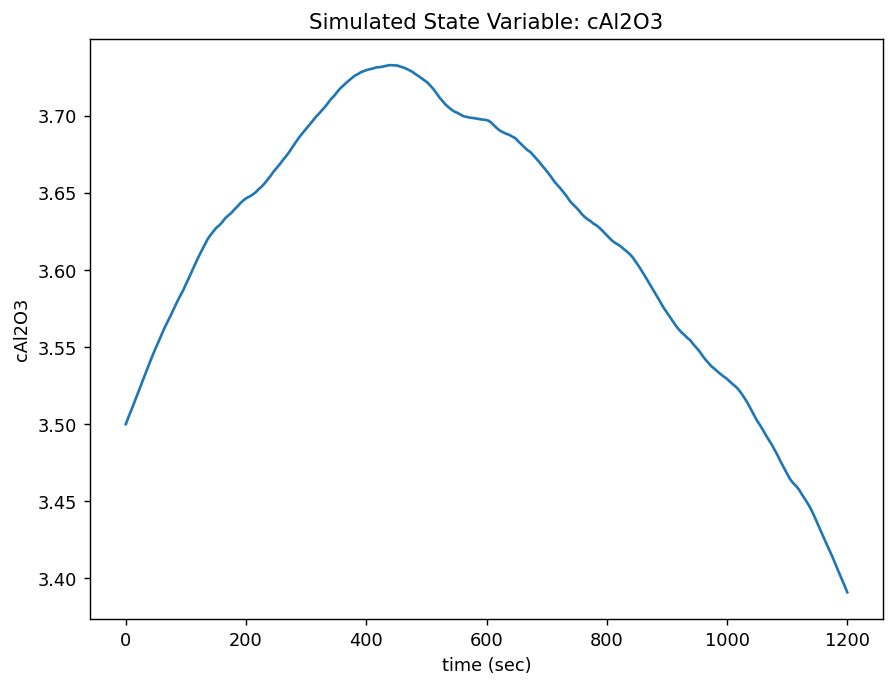

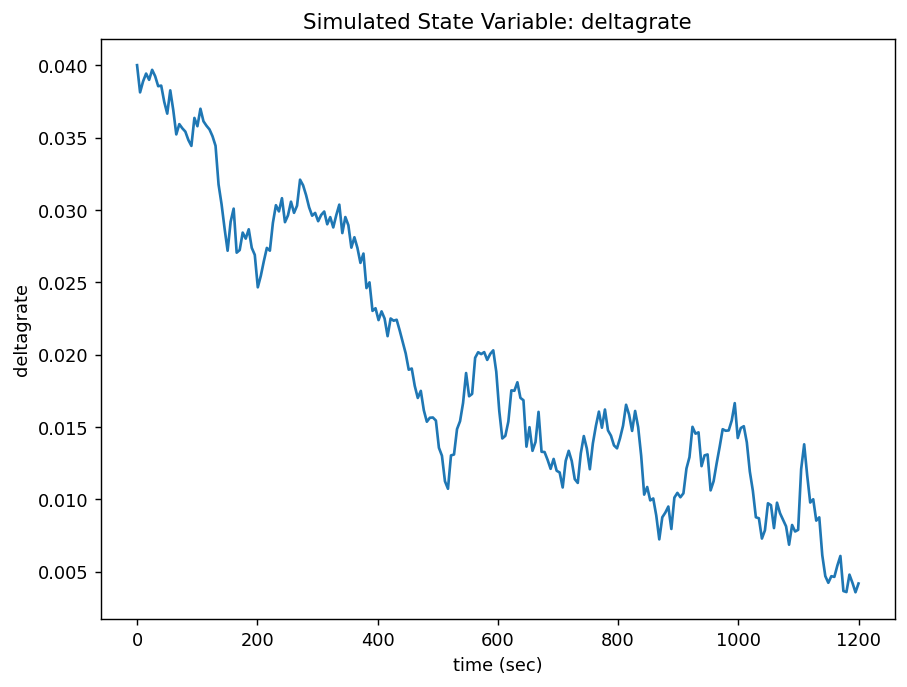

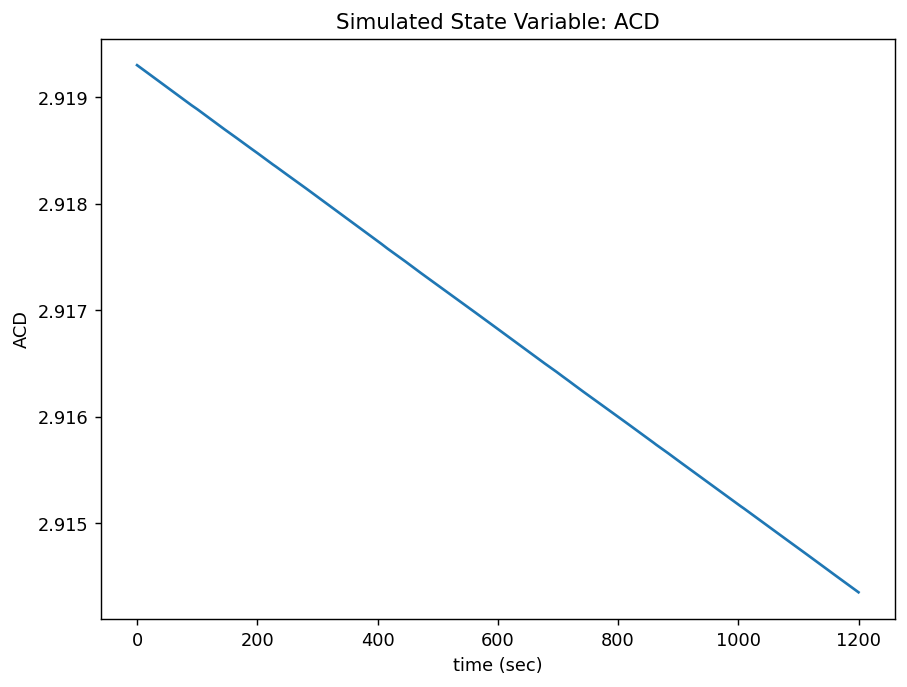

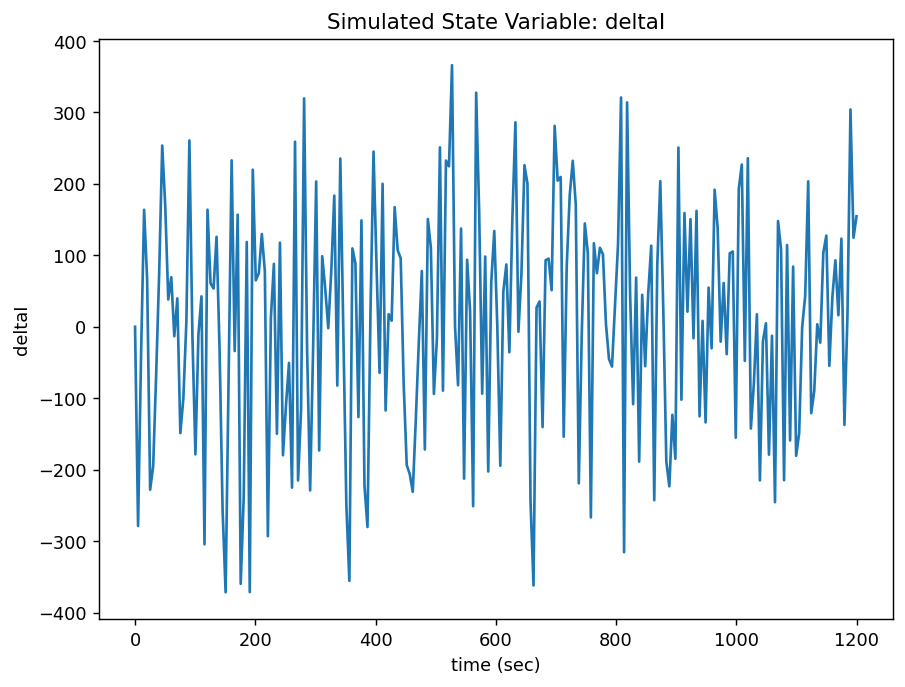

In [53]:
x, u = sim_nofeed(5, 240, bbcell, alumina4state, u0, x0, plotresult=True, statenoise=True)

### Response is more like the old 3 state model BUT
### now delta_g state is effectively the same as undissolved alumina...

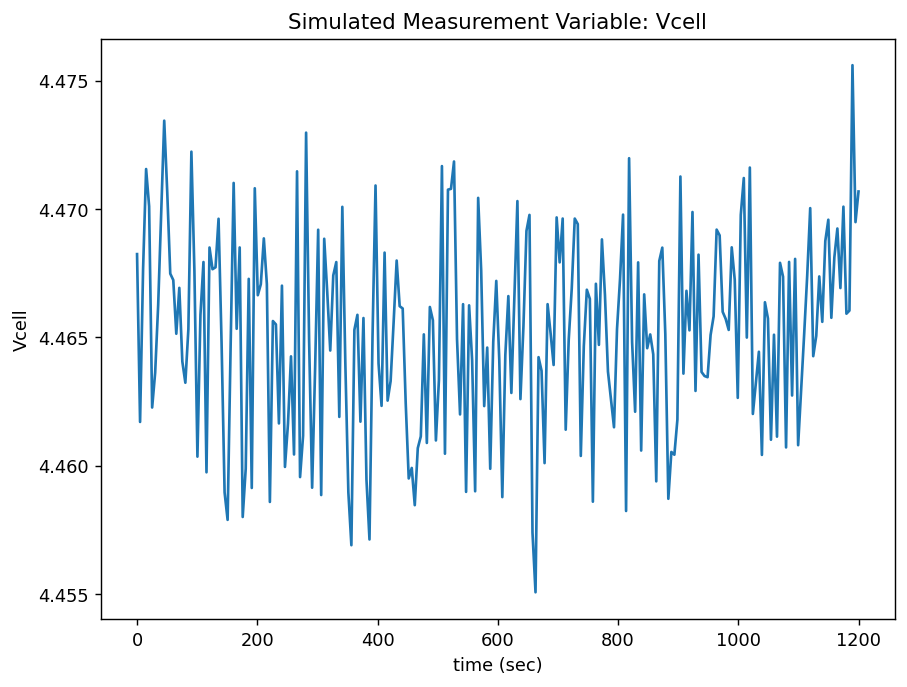

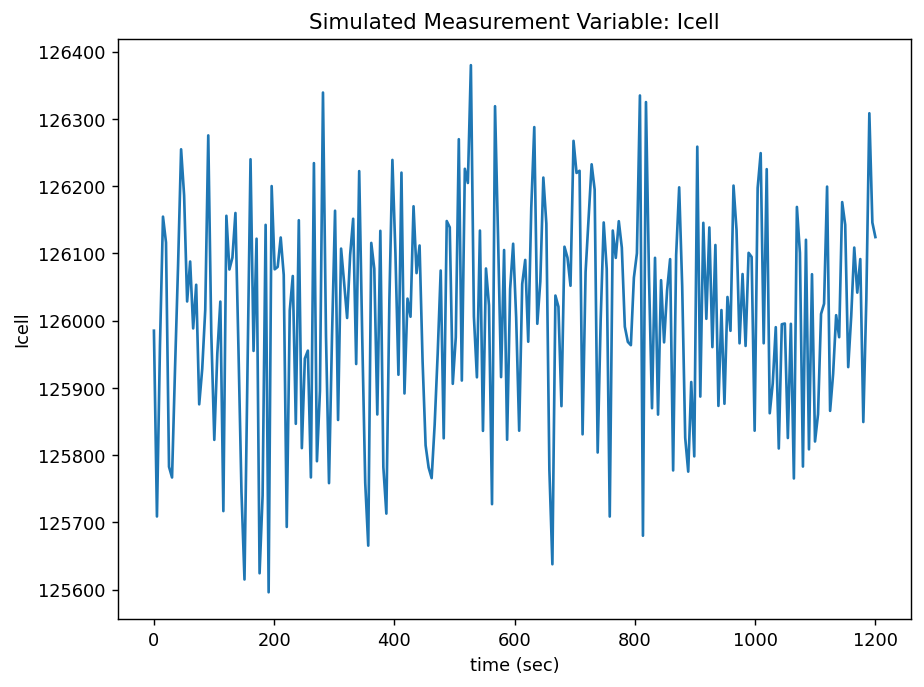

In [54]:
z = sim_observation(5, x, u, bbcell, alumina4state, plotresult=True)